# Country-level losses from extreme El Nino events and global warming
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

Data locations

In [43]:
loc_panel = "../Data/Panel/"
loc_damages = "../Data/Historical_Damages/"
loc_damages_future = "../Data/Damages/"
loc_shp = "../Data/ProcessedCountryShapefile/"
loc_coefs = "../Data/RegressionResults/"
loc_teleconnections = "../Data/Teleconnections/"
loc_summarydata = "../Data/SummaryData/"

#### Analysis

Read shapefile

In [4]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

Read damages

In [5]:
nlag = 5
y1 = 1982
y2 = 2019
event_damages = xr.open_dataset(loc_damages+"ENSO_damages_historical_extreme_elnino_e-and-c_"+str(y1)+"-"+str(y2)+".nc")
gpc_damages_1 = event_damages.gpc_change_pct.loc[1983,:,1988,:].mean(dim="boot")
gpc_damages_2 = event_damages.gpc_change_pct.loc[1998,:,2003,:].mean(dim="boot")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
gpc_damages_2.loc["BRA"]

<xarray.DataArray 'gpc_change_pct' ()>
array(-5.57723721)
Coordinates:
    iso      <U3 'BRA'
    time     int64 2003
    event    int64 1998

In [7]:
gpc_damages_2.loc[["ECU","BRA","IDN"]]

<xarray.DataArray 'gpc_change_pct' (iso: 3)>
array([-19.25141018,  -5.57723721, -11.3271757 ])
Coordinates:
  * iso      (iso) object 'ECU' 'BRA' 'IDN'
    time     int64 2003
    event    int64 1998

Read marginal effects so we know whose effects are significant

In [8]:
response = "gr_pwt_frac" # penn world tables growth
enso_var = "e_e-and-c" # e-index
trend = "none" # no controls for trends
nlag = 5 # cumulative lag length
lags = np.arange(0,nlag+1,1)

coefs_e_name = "ENSO_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_noextreme.csv"
coefs_e = pd.read_csv(loc_coefs+coefs_e_name,index_col=0)
boot = coefs_e.boot.values
coefs_e = xr.DataArray(coefs_e.iloc[:,1:].values,
                            coords=[boot,lags],
                            dims=["boot","lag"])
coefs_e_sum = coefs_e.sum(dim="lag")
coefs_int_name = "ENSO_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+"_sensitivity_noextreme.csv"
coefs_int = pd.read_csv(loc_coefs+coefs_int_name,index_col=0)
coefs_int = xr.DataArray(coefs_int.iloc[:,1:].values,
                            coords=[boot,lags],
                            dims=["boot","lag"])
coefs_int_sum = coefs_int.sum(dim="lag")

# Observed teleconnections
obs_tc = xr.open_dataset(loc_teleconnections+"ENSO_observed_teleconnections_DJF_1960-2019.nc").combined_corr_e_running
obs_tc = obs_tc.where(obs_tc>0,np.nan)

iso_tc = obs_tc.iso.values

coefs_e_xr = coefs_e.expand_dims(iso=iso_tc)
coefs_int_xr = coefs_int.expand_dims(iso=iso_tc)

# calculate marginal effects
me = (coefs_e_xr + coefs_int_xr*obs_tc).sum(dim="lag")
me_lower = me.quantile(0.025,dim="boot")
me_upper = me.quantile(0.975,dim="boot")
significance = ((me_lower < 0)&(me_upper < 0)).astype(int)

Read damages from global warming

In [9]:
persist = "partial"
e1 = "ssp126"
e2 = "ssp585"
e1_nm = "SSP1-2.6"
e2_nm = "SSP5-8.5"
y1_future = 2020
y2_future = 2099
damages1 = xr.open_dataset(loc_damages_future+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e1+"_main_"+persist+"persistence_"+str(y1_future)+"-"+str(y2_future)+".nc")
damages_pct_mean1 = damages1.gpc_change_pct_overall_mean
damages_pct_sd1 = damages1.gpc_change_pct_overall_sd
damages2 = xr.open_dataset(loc_damages_future+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e2+"_main_"+persist+"persistence_"+str(y1_future)+"-"+str(y2_future)+".nc")
damages_pct_mean2 = damages2.gpc_change_pct_overall_mean
damages_pct_sd2 = damages2.gpc_change_pct_overall_sd

In [10]:
rate = 0.02
tm = damages2.gdp_change.time.values
dfact = np.exp(-1*rate*(tm-np.amin(tm)))

In [11]:
per=damages1.gpc_change_pct.sel(iso="PER")

In [12]:
x = per.mean(dim="time").values.flatten()

In [13]:
len(x[x<0])/len(x)

0.7137213114754098

In [14]:
(damages2.gdp_change_mean*dfact).sum(dim="time").loc["RUS"]

<xarray.DataArray 'gdp_change_mean' ()>
array(-3.55228668e+11)
Coordinates:
    iso      <U3 'RUS'

Plot

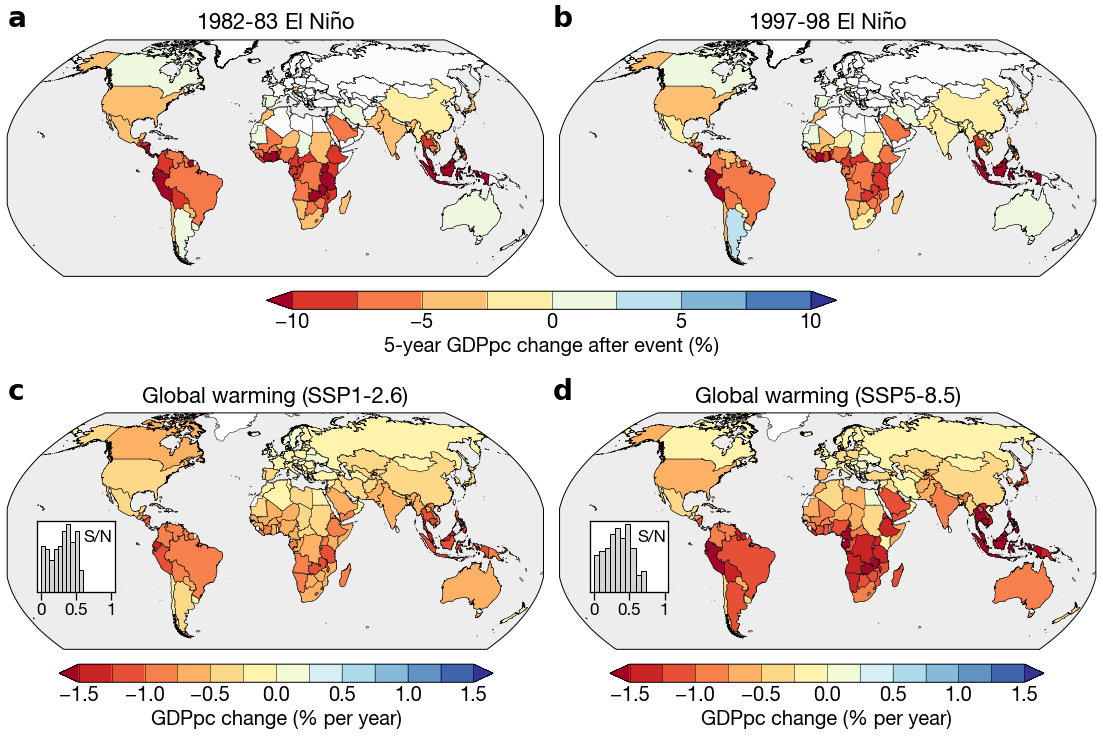

In [15]:
fig = plt.figure(figsize=(18,14))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

tfs = 22

### damages from specific events 

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.94,top=0.85,bottom=0.55,wspace=0.03,hspace=0.23)

ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

cmin = -10
cmax = 10
nrange = 9
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
baseline_col = [0.99,0.99,0.99]

for i in np.unique(gpc_damages_1.iso.values):
    if i in iso_shp:
        val = gpc_damages_1.loc[i]
        if (~np.isnan(val)) & (val!=0.0):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=baseline_col,edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=baseline_col,edgecolor="black",linewidth=0.5)

plt.title("1982-83 El Ni$\~n$o",pad=10,fontsize=tfs)



ax = plt.subplot(gs1[0,1],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])


for i in np.unique(gpc_damages_2.iso.values):
    if i in iso_shp:
        val = gpc_damages_2.loc[i]
        if (~np.isnan(val)) & (val!=0.0):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=baseline_col,edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=baseline_col,edgecolor="black",linewidth=0.5)
        
plt.title("1997-98 El Ni$\~n$o",pad=10,fontsize=tfs)


# colorbar
cbar_ax = fig.add_axes([0.3,0.55,0.44,0.018])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                      drawedges=True,extend="both",ticks=[-10,-5,0,5,10])
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("5-year GDPpc change after event (%)",
             rotation=0,labelpad=5)





### Damages from global warming

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.1,right=0.94,top=0.48,bottom=0.18,wspace=0.03,hspace=0.23)


ax = plt.subplot(gs2[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

cmin = -1.5
cmax = 1.5
nrange = 13
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
baseline_col = [0.99,0.99,0.99]

for i in np.unique(damages_pct_mean1.iso.values):
    if i in iso_shp:
        val = damages_pct_mean1.loc[i]
        if ~np.isnan(val):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=baseline_col,edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=baseline_col,edgecolor="black",linewidth=0.5)

        

plt.title("Global warming ("+e1_nm+")",fontsize=tfs,pad=10)

# colorbar
cbar_ax = fig.add_axes([0.14,0.18,0.335,0.018])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                      drawedges=True,extend="both")
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("GDPpc change (% per year)",
             rotation=0,labelpad=5)



ax = plt.subplot(gs2[0,1],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])


cmin = -1.5
cmax = 1.5
nrange = 13
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
baseline_col = [0.99,0.99,0.99]

for i in np.unique(damages_pct_mean2.iso.values):
    if i in iso_shp:
        val = damages_pct_mean2.loc[i]
        if ~np.isnan(val):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=baseline_col,edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=baseline_col,edgecolor="black",linewidth=0.5)


plt.title("Global warming ("+e2_nm+")",fontsize=tfs,pad=10)

# colorbar
cbar_ax = fig.add_axes([0.565,0.18,0.335,0.018])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                      drawedges=True,extend="both")
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("GDPpc change (% per year)",
             rotation=0,labelpad=5)


## inset for SN
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.width'] = 1.3

inset1 = fig.add_axes([0.123,0.27,0.06,0.07])
inset1.hist(np.abs(damages_pct_mean1/damages_pct_sd1),
           facecolor="lightgray",edgecolor="black")
inset1.set_yticks([])
inset1.set_xlim([-0.05,1.05])
inset1.set_xticks(ticks=[0,0.5,1.0])
inset1.set_xticklabels(labels=["0","0.5","1"],fontsize=17)
inset1.text(0.6,0.7,"S/N",fontsize=17,transform=inset1.transAxes)

inset2 = fig.add_axes([0.55,0.27,0.06,0.07])
inset2.hist(np.abs(damages_pct_mean2/damages_pct_sd2),
           facecolor="lightgray",edgecolor="black")
inset2.set_yticks([])
#inset2.set_ylabel("Frequency",labelpad=10,fontsize=17)
#inset2.set_xlabel("S/N",fontsize=17)
inset2.set_xlim([-0.05,1.05])
inset2.set_xticks(ticks=[0,0.5,1.0])
inset2.set_xticklabels(labels=["0","0.5","1"],fontsize=17)
inset2.text(0.6,0.7,"S/N",fontsize=17,transform=inset2.transAxes)


plt.figtext(0.1,0.83,r'$\bf{a}$',fontsize=28)
plt.figtext(0.52,0.83,r'$\bf{b}$',fontsize=28)

plt.figtext(0.1,0.46,r'$\bf{c}$',fontsize=28)
plt.figtext(0.52,0.46,r'$\bf{d}$',fontsize=28)

plt.savefig("../Figures/FigX_Country_Losses.png",dpi=150)
plt.show()

Output data from each map in a spreadsheet

In [21]:
# gpc_damages_1 is 1983, gpc_damages_2 is 1998
# damages_pct_mean1 is ssp126, damages_pct_mean2 is ssp585

In [50]:
iso_out = np.sort([x for x in damages_pct_mean1.iso.values if x in gpc_damages_1.iso.values])
names = shp.loc[[x in iso_out for x in shp.ISO3.values],"NAME"].values

In [52]:
damages_1983 = gpc_damages_1.loc[iso_out]
damages_1998 = gpc_damages_2.loc[iso_out]
damages_ssp126 = damages_pct_mean1.loc[iso_out]
damages_ssp585 = damages_pct_mean2.loc[iso_out]

In [56]:
df_out = pd.DataFrame({"name":names,"iso":iso_out,
                      "damages_event_1983":damages_1983,
                      "damages_event_1998":damages_1998,
                      "damages_globalwarming_ssp126":damages_ssp126,
                      "damages_globalwarming_ssp585":damages_ssp585})
df_out = df_out.replace(0,np.nan)
df_out.to_csv(loc_summarydata+"damages_summarydata_bycountry.csv")

In [36]:
gpc_damages_1983

<xarray.DataArray 'gpc_change_pct' (iso: 160)>
array([         nan,  -7.32225883,   0.        ,  -5.61014178,
         0.62322231,          nan,   0.21874177,  -2.53608866,
                nan,  -6.48024382,  -2.62194288,  -9.72659055,
        -5.93582563,  -2.00131057,   0.        ,          nan,
                nan,          nan,  -7.67596241,  -6.22418084,
        -8.34157367,   0.10316615,  -5.74331609,  -9.03597083,
         0.27118371,   0.        ,  -4.82673788,  -2.0320186 ,
       -11.10379683,  -9.36007585,  -6.46921566,  -7.7693964 ,
        -8.17254666, -10.41592181,          nan,   0.05481706,
                nan,   0.        ,  -2.97101987,   0.        ,
        -3.41797824,   0.        , -21.12065137,   0.        ,
                nan,   0.22420801,          nan,  -9.04198305,
         0.        ,   0.        ,  -8.63456916,   0.        ,
                nan, -10.54381822,  -6.72882378,          nan,
        -9.24516175,   0.        ,  -7.86107458,  -7.20377074,
                nan,  -8.82425396,          nan,  -2.29169369,
         0.        , -12.73930348,  -3.28705476,   0.        ,
         0.26773472,   0.17173105,   0.        ,   0.10467639,
         0.11783331,   0.16018684,  -2.70148181,          nan,
        -9.31155183,          nan,  -6.90447555,  -4.26224713,
         0.        ,  -3.41004983,  -0.04959409,  -9.20264207,
                nan,  -6.6590126 ,  -2.587287  ,          nan,
        -2.59654515,          nan,          nan,  -3.42091201,
                nan,  -4.53732967,  -2.98391237,          nan,
        -5.24246732,  -2.47766251,          nan,   0.        ,
        -7.75320103,   0.18508534,  -8.18756187, -12.16708824,
        -4.45998507,  -3.71610811,  -6.22963946, -11.94320632,
        -2.4087895 ,   0.        ,   0.18256905,   0.10126382,
         0.        ,  -2.57891918, -11.82291726, -17.56165606,
        -7.47202708,          nan,   0.        ,          nan,
         0.08530693,  -3.06949795,          nan,  -2.33293503,
         0.        ,          nan,  -3.04267405,  -6.50156131,
        -3.15519805,   0.16313893,          nan,  -6.56548993,
        -8.86438917,          nan,          nan, -11.65761728,
                nan,          nan,   0.        ,   0.38105553,
         0.        ,   0.44298388, -11.36355509,  -9.53708674,
                nan,          nan,   0.05686274,   0.        ,
       -10.3589349 , -10.0065676 ,          nan,   0.35183581,
        -3.30625061,          nan,  -5.99105659,  -3.78289275,
                nan,  -3.30593028, -11.26107058,  -6.58759313])
Coordinates:
  * iso      (iso) object 'AFG' 'AGO' 'ALB' 'ARE' ... 'YEM' 'ZAF' 'ZMB' 'ZWE'
    time     int64 1988
    event    int64 1983

In [23]:
damages_pct_mean1

<xarray.DataArray 'gpc_change_pct_overall_mean' (iso: 161)>
array([-0.272177, -0.820261,       nan, -0.293669, -0.279203,       nan,
       -0.552418, -0.161321, -0.1368  , -0.823362,       nan, -0.811117,
       -0.653464, -0.377954, -0.1058  ,       nan, -0.255549,  0.070613,
       -0.779876, -0.850615,       nan, -0.669252, -0.719294, -0.482606,
       -0.501471,       nan, -0.17384 , -0.303235, -0.779683, -0.557613,
       -0.6699  , -0.707239, -0.823666,       nan, -0.496318,       nan,
       -0.050786, -0.150325,       nan, -0.030647,       nan, -0.245133,
       -1.270929, -0.090718, -0.878584, -0.276319, -0.07717 , -0.85918 ,
       -0.074688, -0.214369, -0.867153,  0.014941,  0.043712, -0.723146,
       -0.74098 ,       nan,       nan, -0.092407, -0.520277, -0.860845,
             nan, -0.940784, -0.109211,       nan,  0.004304, -1.248855,
       -0.703028,  0.003265, -0.364736, -0.279167,  0.043436,       nan,
       -0.151949, -0.273617, -0.302417, -0.335403, -0.720711, -0.408183,
       -1.102377, -0.359052,       nan, -0.612647,       nan, -0.824831,
       -0.302549,       nan, -0.589478, -0.135447, -0.174599, -0.004063,
             nan, -0.169866, -0.014135, -0.955336, -0.353342, -0.150977,
       -0.613754, -0.574766,       nan, -0.152668, -0.646695, -0.453464,
       -1.076659, -1.312854, -0.921313, -0.584642, -0.562272, -1.027285,
       -0.152139,  0.072531, -0.493771, -0.207363, -0.060824, -0.535909,
             nan, -1.069469, -1.059611, -0.949701, -0.103486,       nan,
       -0.123282, -0.500677,       nan,       nan, -0.005182, -0.012949,
       -0.576207, -0.674289, -0.316203, -0.641568,       nan,       nan,
             nan, -0.701695, -0.093276, -0.975661, -0.090743, -0.136829,
        0.038052, -0.487864, -0.167419, -0.454225,       nan, -1.057152,
       -0.39759 , -0.103214, -0.175426, -0.102579,       nan, -1.169797,
       -0.851962,  0.057661, -0.230929, -0.434   , -0.312571, -0.753362,
       -0.783458, -0.909683, -0.579077, -1.078319, -0.616224])
Coordinates:
  * iso      (iso) object 'AFG' 'AGO' 'ALB' 'ARE' ... 'YEM' 'ZAF' 'ZMB' 'ZWE'

In [22]:
gpc_damages_1

<xarray.DataArray 'gpc_change_pct' (iso: 266)>
array([         nan,          nan,          nan,          nan,
        -7.32225883,   0.        ,          nan,          nan,
        -5.61014178,   0.62322231,          nan,          nan,
                nan,   0.21874177,  -2.53608866,          nan,
        -6.48024382,  -2.62194288,  -9.72659055,  -5.93582563,
        -2.00131057,   0.        ,          nan,          nan,
                nan,          nan,          nan,          nan,
        -7.67596241,  -6.22418084,          nan,  -8.34157367,
         0.10316615,  -5.74331609,  -9.03597083,   0.27118371,
                nan,   0.        ,          nan,  -4.82673788,
        -2.0320186 , -11.10379683,  -9.36007585,  -6.46921566,
        -7.7693964 ,  -8.17254666,          nan,          nan,
       -10.41592181,          nan,          nan,          nan,
                nan,   0.05481706,          nan,   0.        ,
        -2.97101987,          nan,   0.        ,  -3.41797824,
         0.        ,          nan,          nan,          nan,
                nan,          nan, -21.12065137,   0.        ,
                nan,          nan,   0.22420801,          nan,
        -9.04198305,          nan,          nan,   0.        ,
                nan,   0.        ,          nan,          nan,
...
                nan,          nan,   0.        ,          nan,
                nan,          nan,   0.08530693,  -3.06949795,
                nan,          nan,          nan,          nan,
        -2.33293503,   0.        ,          nan,  -3.04267405,
                nan,  -6.50156131,  -3.15519805,   0.16313893,
                nan,          nan,  -6.56548993,  -8.86438917,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       -11.65761728,          nan,          nan,   0.        ,
         0.38105553,          nan,          nan,   0.        ,
                nan,   0.44298388,          nan,          nan,
       -11.36355509,  -9.53708674,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,   0.05686274,
         0.        ,          nan, -10.3589349 , -10.0065676 ,
                nan,          nan,   0.35183581,  -3.30625061,
                nan,          nan,  -5.99105659,          nan,
                nan,  -3.78289275,          nan,          nan,
                nan,          nan,          nan,  -3.30593028,
       -11.26107058,  -6.58759313])
Coordinates:
  * iso      (iso) object 'ABW' 'AFE' 'AFG' 'AFW' ... 'YEM' 'ZAF' 'ZMB' 'ZWE'
    time     int64 1988
    event    int64 1983